# Unsupervised methods

### Preprocess the dataset for clustering algorithms.

Using only selected features
Transform the features to follow a normal distribution

In [1]:
import pandas as pd

df = pd.read_csv('temp/Delivery_truck_trip_data_df.csv')

In [2]:
irrelevant_columns = df.columns
irrelevant_columns

Index(['Market/Regular', 'vehicle_no', 'OriginLocation_Code',
       'DestinationLocation_Code', 'TRANSPORTATION_DISTANCE_IN_KM',
       'vehicleType', 'Minimum_kms_to_be_covered_in_a_day', 'customerID',
       'supplierID', 'Material Shipped', 'Org_lat', 'Org_lon', 'Des_lat',
       'Des_lon', 'trip_time', 'day', 'month', 'year', 'dayofweek', 'anomaly'],
      dtype='object')

In [3]:
df.reset_index(drop=True, inplace=True)
X = df.drop(['anomaly'], axis=1)
y = df['anomaly']

from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
X = qt.fit_transform(X)

### Create a Table of performance

In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score

table_of_performance = pd.DataFrame(columns=['algorithm', 'confusion matrix', 'accuracy', 'precision', 'recall', 'rand index', 'mutual information based score', 'homogeneity', 'completeness', 'v-measure'])

def add_performance(algorithm, y, y_predict):
    global table_of_performance

    cm = confusion_matrix(y, y_predict)
    accuracy = accuracy_score(y, y_predict)
    precision = precision_score(y, y_predict)
    recall = recall_score(y, y_predict)
    rand_index = rand_score(y, y_predict)
    mutual_info_score = adjusted_mutual_info_score(y, y_predict)
    homogeneity = homogeneity_score(y, y_predict)
    completeness = completeness_score(y, y_predict)
    v_measure = v_measure_score(y, y_predict)
    
    new_row = {'algorithm': algorithm, 'confusion matrix': cm, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'rand index': rand_index, 'mutual information based score': mutual_info_score, 'homogeneity': homogeneity, 'completeness': completeness, 'v-measure': v_measure}

    table_of_performance.loc[len(table_of_performance)] = new_row

### Visualization of clustering after PCA

<Axes: xlabel='x', ylabel='y'>

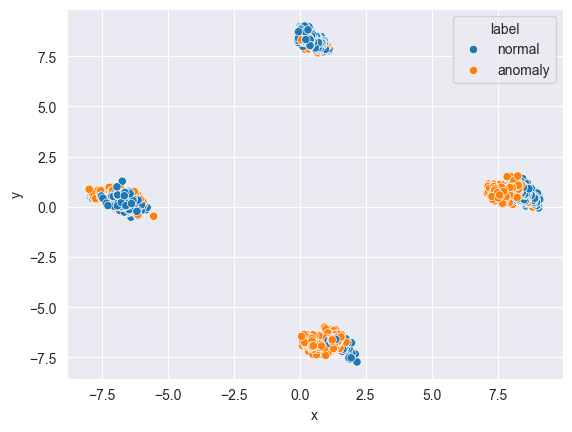

In [5]:

from sklearn.decomposition import  PCA
import numpy as np

pca = PCA(n_components=2)
pct = pca.fit_transform(X)

pct = np.delete(pct, 6745, 0)
y_new = np.delete(y.to_numpy(), 6745, 0)

y_new = ['anomaly' if elem else 'normal' for elem in y_new]

data = pd.concat([pd.DataFrame(pct), pd.DataFrame(y_new)], axis=1)

data.columns = ['x', 'y', 'label']
import seaborn as sns

sns.scatterplot(data=data, x="x", y="y", hue="label")


### KMeans

In [5]:
from sklearn.cluster import KMeans
'''
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()
'''

'\nfrom yellowbrick.cluster import KElbowVisualizer\n\n# Instantiate the clustering model and visualizer\nmodel = KMeans()\nvisualizer = KElbowVisualizer(model, k=(2, 12))\n\nvisualizer.fit(X)        # Fit the data to the visualizer\nvisualizer.show()\n'

The optimal number of clusters is 5.

In [6]:
k_means = KMeans(init="k-means++", n_clusters=2, n_init=10, random_state=103)
k_means.fit(X)

from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

from sklearn.metrics.pairwise import pairwise_distances_argmin_min

k_means_distances_df = pd.DataFrame(pairwise_distances_argmin_min(X, k_means_cluster_centers)).T
k_means_distances_df.columns = ['cluster', 'distance']
k_means_distances_df = pd.concat([k_means_distances_df, y], axis=1)
k_means_distances_df.value_counts(['cluster', 'anomaly'])


cluster  anomaly
0.0      False      2209
1.0      False      2021
         True       1482
0.0      True       1038
Name: count, dtype: int64

In [7]:
y_predict = k_means_distances_df['cluster'].map({0: False, 1: True})
add_performance('KMeans', y, y_predict)


### Affinity Propagation

In [8]:
'''
from scipy.spatial.distance import pdist

max(pdist(X))
'''

'\nfrom scipy.spatial.distance import pdist\n\nmax(pdist(X))\n'

In [9]:
'''
from sklearn.cluster import AffinityPropagation

pca = PCA(n_components=3)
pct = pca.fit_transform(X)
af = AffinityPropagation(random_state=0).fit(pct)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
len(cluster_centers_indices)
'''

'\nfrom sklearn.cluster import AffinityPropagation\n\npca = PCA(n_components=3)\npct = pca.fit_transform(X)\naf = AffinityPropagation(random_state=0).fit(pct)\ncluster_centers_indices = af.cluster_centers_indices_\nlabels = af.labels_\nlen(cluster_centers_indices)\n'

Can't specify the number of clusters

### Mean Shift

In [10]:
'''
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X, quantile=0.3)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
'''

'\nfrom sklearn.cluster import MeanShift, estimate_bandwidth\n\nbandwidth = estimate_bandwidth(X, quantile=0.3)\n\nms = MeanShift(bandwidth=bandwidth, bin_seeding=True)\nms.fit(X)\nlabels = ms.labels_\ncluster_centers = ms.cluster_centers_\n'

In [11]:
'''
mean_shift_distances_df = pd.DataFrame(pairwise_distances_argmin_min(X, cluster_centers)).T
mean_shift_distances_df.columns = ['cluster', 'distance']
mean_shift_distances_df = pd.concat([mean_shift_distances_df, y], axis=1)
print(mean_shift_distances_df.groupby(['cluster', 'ontime']).mean())
print(mean_shift_distances_df.groupby(['cluster', 'ontime']).count())
'''

"\nmean_shift_distances_df = pd.DataFrame(pairwise_distances_argmin_min(X, cluster_centers)).T\nmean_shift_distances_df.columns = ['cluster', 'distance']\nmean_shift_distances_df = pd.concat([mean_shift_distances_df, y], axis=1)\nprint(mean_shift_distances_df.groupby(['cluster', 'ontime']).mean())\nprint(mean_shift_distances_df.groupby(['cluster', 'ontime']).count())\n"

In cluster 1 and 3, most are on time. In cluster 2, most are not on time. In clusters 0, almost half of the points are anomalies.

In cluster 2, almost half are anomalies. In cluster 0 and 3, most are not anomalies. In cluster 1 most are anomalies.

### Hierarchical clustering

In [12]:
from sklearn.cluster import AgglomerativeClustering

hierarchical_clustering = AgglomerativeClustering(n_clusters=2).fit(X)

In [13]:
hierarchical_clustering_labels_df = pd.DataFrame(hierarchical_clustering.labels_, columns=['cluster'])
hierarchical_clustering_labels_df = pd.concat([hierarchical_clustering_labels_df, y], axis=1)
pd.DataFrame(hierarchical_clustering_labels_df.value_counts())


count
cluster anomaly       
1       False     2358
0       True      2119
        False     1872
1       True       401

In [14]:
y_predict = hierarchical_clustering_labels_df['cluster'].map({0: True, 1: False})
add_performance('hierarchical clustering', y, y_predict)


### HDBSCAN

In [15]:
from sklearn.cluster import HDBSCAN

hdb = HDBSCAN(min_cluster_size=20)
hdb.fit(X)

HDBSCAN(min_cluster_size=20)

In [16]:
hdbscan_labels_df = pd.DataFrame(hdb.labels_, columns=['clusters'])
hdbscan_labels_df = pd.concat([hdbscan_labels_df, y], axis=1)
hdbscan_labels_df[hdbscan_labels_df.clusters==-1].value_counts()

clusters  anomaly
-1        False      557
          True       223
Name: count, dtype: int64

In [17]:
y_predict = hdbscan_labels_df['clusters'].map(lambda x: x < 0)
add_performance('HDBSCAN', y, y_predict)

### OPTICS

In [18]:
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=2).fit(X)

/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_optics.py:995: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [19]:
optics_labels_df = pd.DataFrame(optics.labels_, columns=['clusters'])
optics_labels_df = pd.concat([optics_labels_df, y], axis=1)
optics_labels_df.value_counts()

clusters  anomaly
-1        False      1185
          True        715
 1298     False         8
 181      True          8
 911      False         8
                     ... 
 238      True          1
 1370     True          1
 460      True          1
 463      False         1
 279      False         1
Name: count, Length: 1958, dtype: int64

In [20]:
y_predict = optics_labels_df['clusters'].map(lambda x: x < 0)
add_performance('OPTICS', y, y_predict)

### BIRCH

In [21]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=2)
brc.fit(X)
brc.predict(X)

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
brc_labels_df = pd.DataFrame(brc.labels_, columns=['cluster'])
brc_labels_df = pd.concat([brc_labels_df, y], axis=1)
brc_labels_df.value_counts()


cluster  anomaly
1        False      2358
0        True       2119
         False      1872
1        True        401
Name: count, dtype: int64

In [23]:
y_predict = brc_labels_df['cluster'].map({0: True, 1: False})
add_performance('BIRCH', y, y_predict)


### Spectral clustering

In [24]:
'''
from sklearn.cluster import SpectralClustering
import joblib

spectral_clustering = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0).fit(X)
joblib.dump(spectral_clustering, 'temp/Delivery_truck_trip_data_spectral_clustering_model.pkl')
'''

"\nfrom sklearn.cluster import SpectralClustering\nimport joblib\n\nspectral_clustering = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0).fit(X)\njoblib.dump(spectral_clustering, 'temp/Delivery_truck_trip_data_spectral_clustering_model.pkl')\n"

In [25]:
# loaded_model = joblib.load('temp/Delivery_truck_trip_data_spectral_clustering_model.pkl')

In [26]:
'''
print(pd.DataFrame(loaded_model.labels_).value_counts())
spectral_clustering_labels_df = pd.DataFrame(spectral_clustering.labels_, columns=['cluster'])
spectral_clustering_labels_df = pd.concat([spectral_clustering_labels_df, y], axis=1)
print(spectral_clustering_labels_df['cluster'].value_counts())
print(spectral_clustering_labels_df.value_counts())
print(spectral_df.value_counts())
'''

"\nprint(pd.DataFrame(loaded_model.labels_).value_counts())\nspectral_clustering_labels_df = pd.DataFrame(spectral_clustering.labels_, columns=['cluster'])\nspectral_clustering_labels_df = pd.concat([spectral_clustering_labels_df, y], axis=1)\nprint(spectral_clustering_labels_df['cluster'].value_counts())\nprint(spectral_clustering_labels_df.value_counts())\nprint(spectral_df.value_counts())\n"

### Performance

In [27]:
table_of_performance.to_csv('temp/Delivery_truck_trip_data_unsupervised_performance.csv', index=False)